# Model Training Pipeline

## Install and Import Dependencies

In [53]:
pip install --upgrade pip && pip install numpy pandas matplotlib keras tf2onnx 

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.models import Model
from keras.layers import Flatten, Dense

from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

2025-09-20 11:40:16.433526: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-20 11:40:16.439366: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-20 11:40:16.489839: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-20 11:40:16.490002: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-20 11:40:16.491287: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

## Prepare Data

In [3]:
train_datagen = ImageDataGenerator(
    zoom_range = 0.2,
    shear_range = 0.2,
    horizontal_flip = True,
    rescale = 1/255
    )

train_data = train_datagen.flow_from_directory(directory = "/work/train",
                                            target_size = (224, 224),
                                            batch_size = 32
                                            )

train_data.class_indices

Found 350 images belonging to 7 classes.


{'Angry': 0,
 'Disguist': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

In [4]:
val_datagen = ImageDataGenerator(rescale = 1/255)

val_data = val_datagen.flow_from_directory(directory = "/work/train",
                                        target_size = (224, 224),
                                        batch_size = 32
                                        )

Found 350 images belonging to 7 classes.


## Visual Data

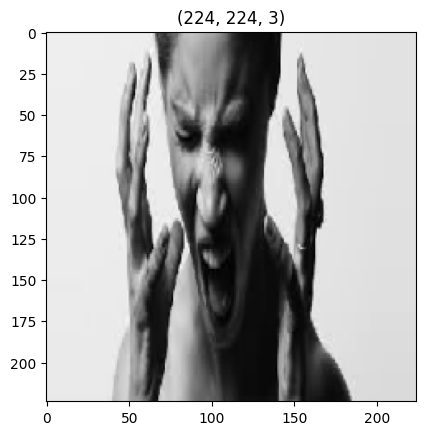

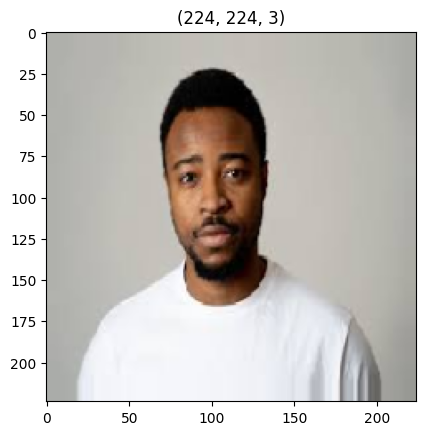

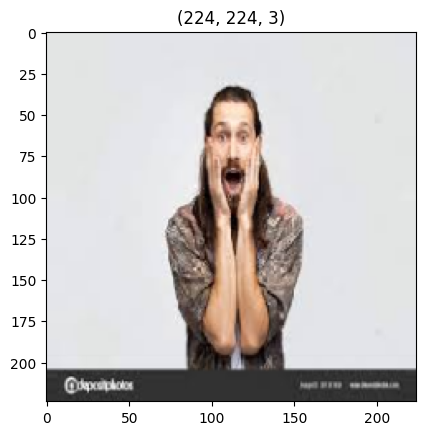

In [5]:
def plotImages(img_arr, labels):
    count = 0
    for img, l in zip(img_arr, labels):
        plt.imshow(img)
        plt.title(img.shape)
        plt.axis = False
        plt.show()

        count += 1
        if count == 3:
            break;



t_img, labels = train_data.next()
plotImages(t_img, labels)

## Build Model

In [6]:
base_model = MobileNet( input_shape=(224, 224, 3), include_top = False)

for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(units=7, activation='softmax')(x)

model = Model(base_model.input, x)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Add Early Stopping and Model Check Point

In [9]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

early_stop = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.1, patience = 5, verbose = 1, mode = 'auto')

model_checkpoint = ModelCheckpoint(filepath = "/work/emotion_detector.h5", monitor = "val_accuracy", verbose = 1, save_best_only = True, mode = 'auto')

call_back = [early_stop, model_checkpoint]

In [10]:
hist = model.fit_generator(train_data, steps_per_epoch = 10,
                        epochs = 30, 
                        validation_data = val_data, 
                        validation_steps = 8, 
                        callbacks = call_back)

/tmp/ipykernel_3007/1495547307.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(train_data, steps_per_epoch = 10,
Epoch 1/30
10/10 [==============================] - ETA: 0s - loss: 9.5439 - accuracy: 0.2264 
Epoch 1: val_accuracy improved from -inf to 0.49609, saving model to /work/emotion_detector.h5
/root/venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
10/10 [==============================] - 90s 9s/step - loss: 9.5439 - accuracy: 0.2264 - val_loss: 3.7876 - val_accuracy: 0.4961
Epoch 2/30
10/10 [==============================] - ETA: 0s - loss: 3.6840 - accuracy: 0.5692
Epoch 2: val_accuracy improved from 0.49609

In [11]:
from keras.models import load_model
model = load_model("/work/emotion_detector.h5")

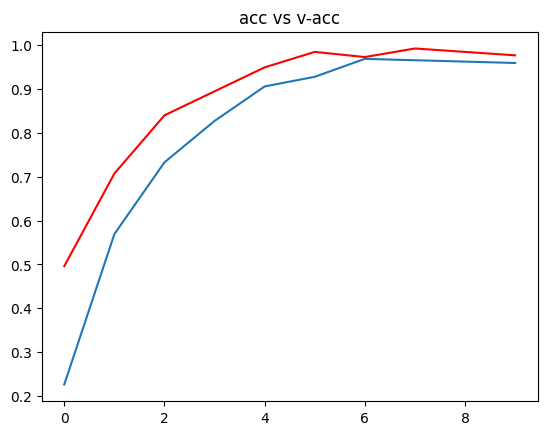

In [12]:
h = hist.history
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c = 'red')
plt.title("acc vs v-acc")
plt.show()

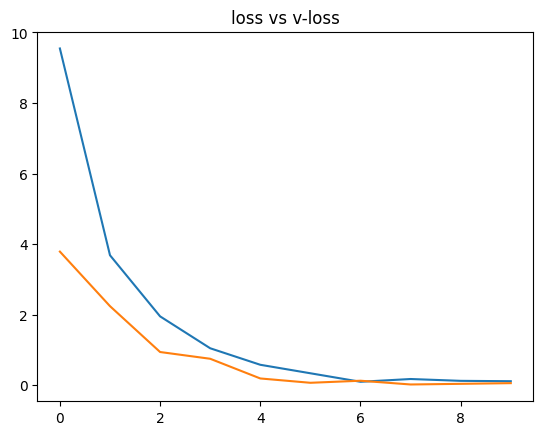

In [13]:
plt.plot(h['loss'])
plt.plot(h['val_loss'])
plt.title("loss vs v-loss")
plt.show()

## Test Model

1/1 [==============================] - 0s 39ms/step
The person is Happy


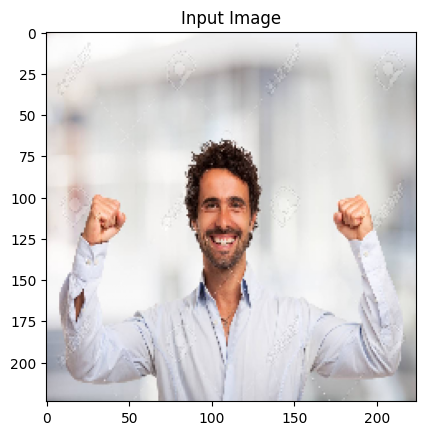

In [35]:
path = "/work/test.jpg"
op = dict(zip(train_data.class_indices.values(), train_data.class_indices.keys()))

img = load_img(path, target_size = (224, 224))


i = img_to_array(img)/255
input_arr = np.array([i])
input_arr.shape

pred = np.argmax(model.predict(input_arr))

print(f"The person is {op[pred]}")

plt.imshow(input_arr[0])
plt.title("Input Image")
plt.show()

## Convert Model Format to ONNX 

In [62]:
import tensorflow as tf
import tf2onnx

model = tf.keras.models.load_model("emotion_detector.h5")
spec = (tf.TensorSpec((1, 224, 224, 3), tf.float32, name="input"),)
model_proto, _ = tf2onnx.convert.from_keras(
    model,
    input_signature=(tf.TensorSpec((1,224,224,3), tf.float32, name="input"),),
    opset=13,
    inputs_as_nchw=["input"]   # force channels-first
)

with open("/work/emotion_detector.onnx", "wb") as f:
    f.write(model_proto.SerializeToString())

2025-09-20 12:21:25.104170: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2025-09-20 12:21:25.104663: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-09-20 12:21:25.562723: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2025-09-20 12:21:25.564268: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
